## Segmentation of User Interaction Logs using Time Series Methods

A demo case used for the idea paper at BPM Technology Forum 2025

#### Execution environment of experiments in the paper:
Windows 11, 16 GB Ram, Python 3.12

#### Execution times for experiments:

Experiment A) Context Parameter Selection: ~5 Min per selected parameter

Experiment B) Window Size Impact: 80-100 Minutes

Experiment C) Motif Count Impact: Mainly the Matrix Profil Calculation, ~5 Min

Experiment D) Cluster Purity: 3-5 Minutes per Matrix Profil Calculation

In [4]:
import pandas as pd
import numpy as np
import stumpy
from stumpy import config
import ast

from gensim.models import Word2Vec
from sklearn.preprocessing import LabelEncoder

import util.util
import matplotlib as plt
import pm4py
import matplotlib.pyplot as plt
import seaborn as sns

import time
from datetime import datetime

#### Data Gathering

Read the Logs that should be discovered from the folder "Leno".

Adjust the file names according to your needs:
1. SRRT_Plus => The file that contains the sequentially ordered traces
2. SRRT_Parallel => The file that contains the alternating traces

In [5]:
file_path = 'Leno/'
# The following two files were used in the Experiment in the paper
srrt_plus_filename = "experiment_extended_SR_RT_plus.csv"
srrt_parallel_filename = "experiment_extended_SR_RT_parallel.csv"

text_encoding_method = "utf-8"
seperator ='' ";"

srrt_plus_log = pd.read_csv(file_path + srrt_plus_filename, encoding=text_encoding_method, sep=seperator)
srrt_parallel_log = pd.read_csv(file_path + srrt_parallel_filename, encoding=text_encoding_method, sep=seperator)

# 1. Single Log Execution

### 1.A. Single Word2Vec Discovery

Single Sentence Word2Vec encoding

In [ ]:
# ---- Inputs ----
# Select the log to discover motifs from
# log_to_discover = srrt_plus_log
# log_to_discover_name = "SRRT_Plus"
# OR
log_to_discover = srrt_parallel_log
log_to_discover_name = "SRRT_Parallel"

size = 65
motifs_to_discover = 100
threshold = 0.8

columns_to_use = ["targetApp","eventType","url","target.workbookName","target.sheetName","target.id","target.class","target.tagName","target.type","target.name","target.innerText","target.checked","target.href","target.option","target.title","target.innerHTML"]

# ---- Single Log execution ----
case_id_list = util.util.generate_caseid_list(log_to_discover, column="caseid")
cases_df = pd.DataFrame(case_id_list, columns=["caseid", "start_index", "length"])
groundTruth = cases_df["start_index"].tolist()
ui_log_encoded_w2v = util.util.encode_word2vec(log_to_discover, orderedColumnsList=columns_to_use, vector_size=50)
motif_distances, motif_indices, motif_subspaces, motif_mdls = util.util.mine_w2v(ui_log_encoded_w2v,size,motifs_to_discover)
print(f"Discovered Motif Indexes: {sorted(motif_indices[0])}")

print(f"Ground Truth:{np.sort(groundTruth)}")

# ---- Measuring Method: Half the Window Size ----
# insert_spots, motif_spots, overlapDF = util.util.compare_sets(set(groundTruth), set(motif_indices[0]), (size/2))
original_inserts_indexes, discovered_motif_spots, overlapDF = util.util.compute_discovery_coverage(case_id_list, set(motif_indices[0]), size, threshold=threshold)
mean_coverage = 0

if 'coverage' in overlapDF.columns:
    mean_coverage = overlapDF.loc[:, "coverage"].mean()

ground_truth_sum = len(groundTruth)
true_positives = len(original_inserts_indexes)
false_positives = motifs_to_discover - true_positives  # Incorrectly identified motifs
false_negatives = ground_truth_sum - true_positives  # Relevant motifs not identified

# Precision
precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
print(f"Precision: {precision}")

# Recall
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
print(f"Recall: {recall}")

# F1-Score
f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
print(f"F1-Score: {f1_score}")

# Create a figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- Bar Chart ---
metrics = ['F1-Score', 'Recall', 'Precision', 'Coverage']
values = [f1_score, recall, precision, mean_coverage]
axes[0].bar(metrics, values, color='skyblue')
axes[0].set_ylim(0, 1.05)  # Slightly higher to leave space for label

axes[0].set_title('Performance Metrics', fontsize=14)
axes[0].set_ylabel('Score', fontsize=12)

for i, v in enumerate(values):
    if v > 0.5:
        offset = -0.05 if v > 0.98 else 0.02  # Push label down if bar is too high
        axes[0].text(i, v + offset, f"{v:.2f}", ha='center', va='top' if offset < 0 else 'bottom', fontsize=10)

axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# --- Violin Plot with Points for IoU ---
sns.violinplot(y=overlapDF["coverage"], ax=axes[1], inner=None, color='lightblue')
sns.stripplot(y=overlapDF["coverage"], ax=axes[1], color='black', size=3, jitter=0.2)
axes[1].set_title("Coverage Distribution (Violin Plot)", fontsize=14)
axes[1].set_ylabel("Coverage", fontsize=12)
axes[1].grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

## 1.B. Clustering of discovered Routines

DBSCAN Clustering of the identified routines from the data of the previous step. So executed 1.A. first.


Routine -1 (total motifs: 49):
  Length 61: 41 motifs (83.7%)
  Length 62: 3 motifs (6.1%)
  Length 64: 1 motifs (2.0%)
  Length 88: 1 motifs (2.0%)
  Length 90: 1 motifs (2.0%)
  Length 92: 1 motifs (2.0%)
  Length 93: 1 motifs (2.0%)

Routine -1 (total motifs: 49):
Lengths in [26–36]: 0 motifs (0.0%)
Lengths in [56–66]: 45 motifs (91.8%)


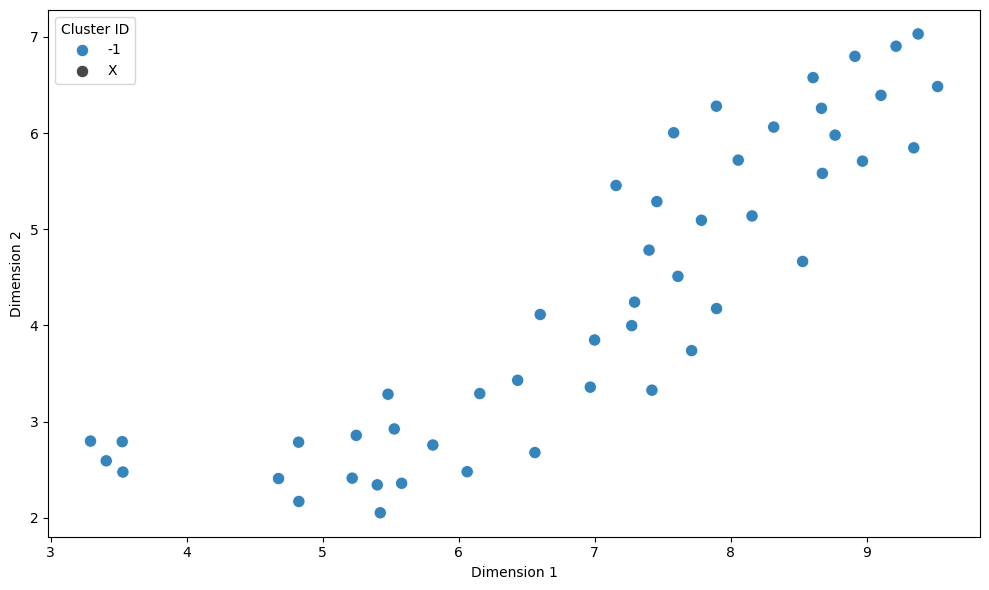

In [ ]:
# ---- Example Usage ----
# Date: ui_log = your full DataFrame with word2vec columns
#          motif_starts = list of discovered motif start indices
#          window_size = length of each motif

df_clusters = util.util.cluster_motifs_with_word2vec(ui_log_encoded_w2v, overlapDF["discoveredMotif"].tolist(), size)
util.util.plot_motif_clusters(df_clusters)

# Create a mapping from start_index to length
length_map = dict(zip(overlapDF["discoveredMotif"], overlapDF["groundTruthLength"]))

# Add 'length' to each motif in df_clusters
df_clusters["length"] = df_clusters["start_index"].map(length_map)

# ---- Print cluster metrics ----
# Group and count motif lengths per cluster
cluster_length_counts = df_clusters.groupby("routine_id")["length"].value_counts()

# Normalize to get total motifs per cluster
cluster_totals = df_clusters.groupby("routine_id")["length"].count()

# Print with percentages
for routine_id, group in cluster_length_counts.groupby(level=0):
    total = cluster_totals[routine_id]
    print(f"\nRoutine {routine_id} (total motifs: {total}):")
    for (rid, length), count in group.items():
        percentage = (count / total) * 100
        print(f"  Length {length}: {count} motifs ({percentage:.1f}%)")

# SR and RT boundaries from Leno Paper to define the cluster range
short_range = (26, 36)  # 31 ± 5
long_range = (56, 66)   # 61 ± 5

# Group by cluster
clustered = df_clusters.groupby("routine_id")["length"]

# Compute and print
for routine_id, lengths in clustered:
    total = len(lengths)
    count_short = sum(lengths.between(*short_range))
    count_long = sum(lengths.between(*long_range))
    
    percent_short = (count_short / total) * 100 if total > 0 else 0
    percent_long = (count_long / total) * 100 if total > 0 else 0
    
    print(f"\nRoutine {routine_id} (total motifs: {total}):")
    print(f"Lengths in [26–36]: {count_short} motifs ({percent_short:.1f}%)")
    print(f"Lengths in [56–66]: {count_long} motifs ({percent_long:.1f}%)")

# ---- Save the clusters ----
# df_clusters.to_csv(f'ExperimentResult/ClusteredMotifs_{log_to_discover_name}_{timestamp}.csv', index=False)

# 2. Automated Experiment for multiple window sizes

### Word2Vec Encoding Based

Experiment A) Impact of column selection on discovery result (EX1)

Experiment B) Impact of window size on discovery result (EX2)

Experiment C) Impact of discovered motifs on discovery result (EX3)

#### A) Fixed Window Size, Fixed Motif to Discover, Different Context Columns

w_s = 30, t=10, Context Columns fluctuating

In the paper referred to as Step 1/ Experiment 1

Processing Columns: ['targetApp']
[(450, 32), (593, 32), (1166, 30), (1734, 32), (2164, 32), (3309, 32), (3593, 30)]
Processing Columns: ['targetApp', 'eventType']
[(80, 61), (223, 61), (364, 61), (507, 61), (650, 61), (793, 61), (1021, 92), (1221, 61), (1364, 61), (1507, 61)]
Processing Columns: ['targetApp', 'eventType', 'url']
[(80, 61), (223, 61), (364, 61), (507, 61), (650, 61), (793, 61), (1021, 92), (1221, 61), (1364, 61), (1507, 61)]
Processing Columns: ['targetApp', 'eventType', 'url', 'target.workbookName']
[(80, 61), (364, 61), (934, 62), (1791, 61), (3223, 61), (3507, 61), (5511, 61), (6084, 61), (6227, 61), (6657, 61)]
Processing Columns: ['targetApp', 'eventType', 'url', 'target.workbookName', 'target.sheetName']
[(80, 61), (223, 61), (364, 61), (507, 61), (650, 61), (793, 61), (1021, 92), (1221, 61), (1364, 61), (1507, 61)]
Processing Columns: ['targetApp', 'eventType', 'url', 'target.workbookName', 'target.sheetName', 'target.id']
[(507, 61), (650, 61), (1021, 92), (164

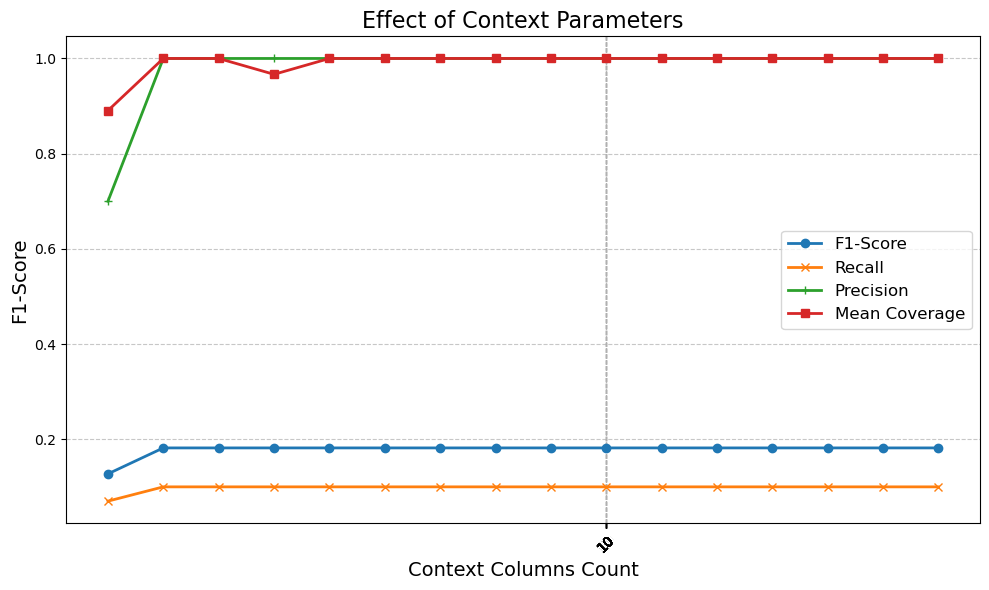

In [ ]:
# ---- Inputs ----
# Select the log to discover motifs from
# log_to_discover = srrt_plus_log
# log_to_discover_name = "SRRT_Plus"
# OR
log_to_discover = srrt_parallel_log
log_to_discover_name = "SRRT_Parallel"

# All Context Columns
ContextColumns = ["targetApp","eventType","url","target.workbookName","target.sheetName","target.id","target.class","target.tagName","target.type","target.name","target.innerText","target.checked","target.href","target.option","target.title","target.innerHTML"]

size = 30
NumberOfMotifsToDiscover = 10
threshold = 0.8

# If set to true, the experiment results will be saved to the folder "ExperimentResult"
save_experiment_to_folder = True

#########################
# ---- Do not change ----
#########################
# ---- Clean log ----
if "tuple:id" in log_to_discover.columns:
    log_to_discover = log_to_discover.drop(columns=["tuple:id"])


case_id_list = util.util.generate_caseid_list(log_to_discover, column="caseid")
cases_df = pd.DataFrame(case_id_list, columns=["caseid", "start_index", "length"])
groundTruth = cases_df["start_index"].tolist()
groundTruth_set = set(groundTruth)
ground_truth_sum = len(groundTruth)

# ---- Results container ----
results = []

# ---- Main loop ----

discovery_repeat = False
start = 1
for i in range(start, len(ContextColumns) + 1):
    contextColumnSelection = ContextColumns[:i]
    ui_log_encoded_w2v = util.util.encode_word2vec(log_to_discover, orderedColumnsList=contextColumnSelection, vector_size=50)

    print(f"Processing Columns: {contextColumnSelection}")
    motif_distances, motif_indices, motif_subspaces, motif_mdls = util.util.mine_w2v(ui_log_encoded_w2v,size,NumberOfMotifsToDiscover)

    discovered_set = set(motif_indices[0])
    
    if discovered_set or discovery_repeat:

        # insert_spots, motif_spots, overlapDF = util.util.compare_sets(groundTruth_set, discovered_set, (size/2))
        original_inserts_indexes, discovered_motif_spots, overlapDF = util.util.compute_discovery_coverage(case_id_list, set(motif_indices[0]), size, threshold=threshold)
        mean_coverage = 0

        if 'coverage' in overlapDF.columns:
            mean_coverage = overlapDF.loc[:, "coverage"].mean()
        else:
            mean_coverage = 0

        true_positives = len(original_inserts_indexes)
        false_positives = NumberOfMotifsToDiscover - true_positives
        false_negatives = ground_truth_sum - true_positives
        
        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
        f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        # Filter the length of the discovered motifs
        filtered_df = cases_df[cases_df["start_index"].isin(original_inserts_indexes)]
        motif_length_list = list(filtered_df[["start_index", "length"]].itertuples(index=False, name=None))

        # print(f"Loop {size} completed. Results appending. F1-Score: {f1_score}, Precision: {precision}, Recall: {recall}, IuO: {mean_iou}.")
        results.append({
            'window_size': size,
            'precision': precision,
            'recall': recall,
            'f1_score': f1_score,
            'mean_coverage': mean_coverage,
            'discovered_indexes': sorted(set(overlapDF[["groundTruthStart", "groundTruthLength"]].itertuples(index=False, name=None))),
            'discovered_motif_spots': set(discovered_motif_spots),
            'motif_count': NumberOfMotifsToDiscover,
            'context_columns': contextColumnSelection,
            'context_columns_count': i
        })
        discovery_repeat = False
    else:
        discovery_repeat = True


# ---- Save the results ----
results_df = pd.DataFrame(results)
timestamp = datetime.now().strftime("%y%m%d_%H%M")
if save_experiment_to_folder:
    results_df.to_csv(f'ExperimentResult/ColumnScore-EX1_{log_to_discover_name}_{timestamp}.csv', index=False)
# print(results_df)

# ---- Plot F1-Score vs Window Size ----
plt.figure(figsize=(10, 6))
plt.plot(results_df['context_columns_count'], results_df['f1_score'], marker='o', linewidth=2, label='F1-Score')
plt.plot(results_df['context_columns_count'], results_df['recall'], marker='x', linewidth=2, label='Recall')
plt.plot(results_df['context_columns_count'], results_df['precision'], marker='+', linewidth=2, label='Precision')
plt.plot(results_df['context_columns_count'], results_df['mean_coverage'], marker='s', linewidth=2, label='Mean Coverage')

plt.title('Effect of Context Parameters', fontsize=16)
plt.xlabel('Context Columns Count', fontsize=14)
plt.ylabel('F1-Score', fontsize=14)
plt.xticks(results_df['motif_count'], rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.legend(fontsize=12)
# ---- Save to file ----
if save_experiment_to_folder:
    plt.savefig(f"ExperimentResult/EX1-ColumnScore_{log_to_discover_name}_plot_{timestamp}.png", dpi=300, bbox_inches='tight')

### B) Fixed Number of motifs with changing window size
Fixed t=10, w_S = range(26,68)

In the paper referred to as Step 2 / Experiment 2

Processing size: 55
Processing size: 58
Processing size: 61
Processing size: 64
Processing size: 67


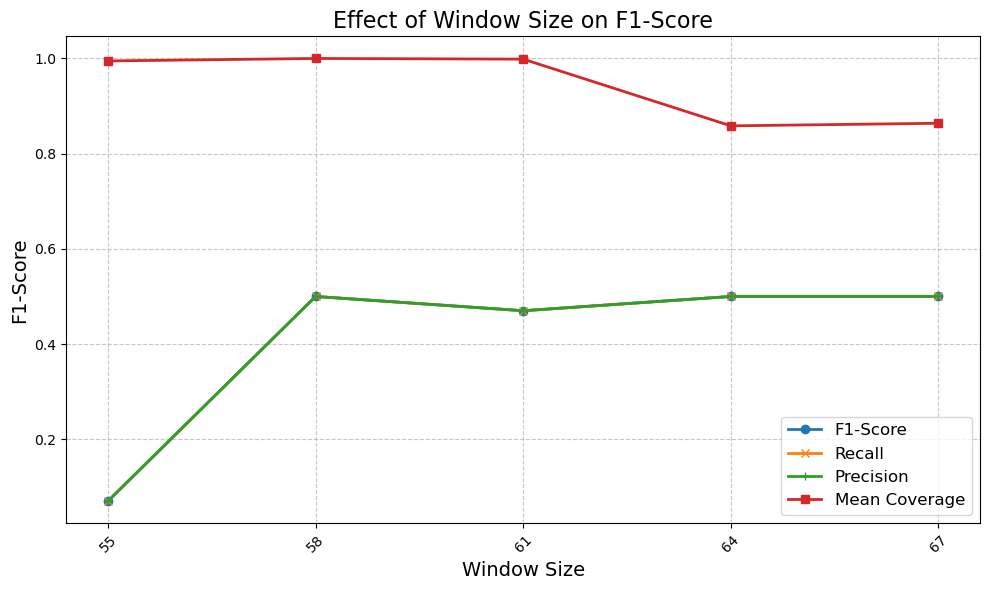

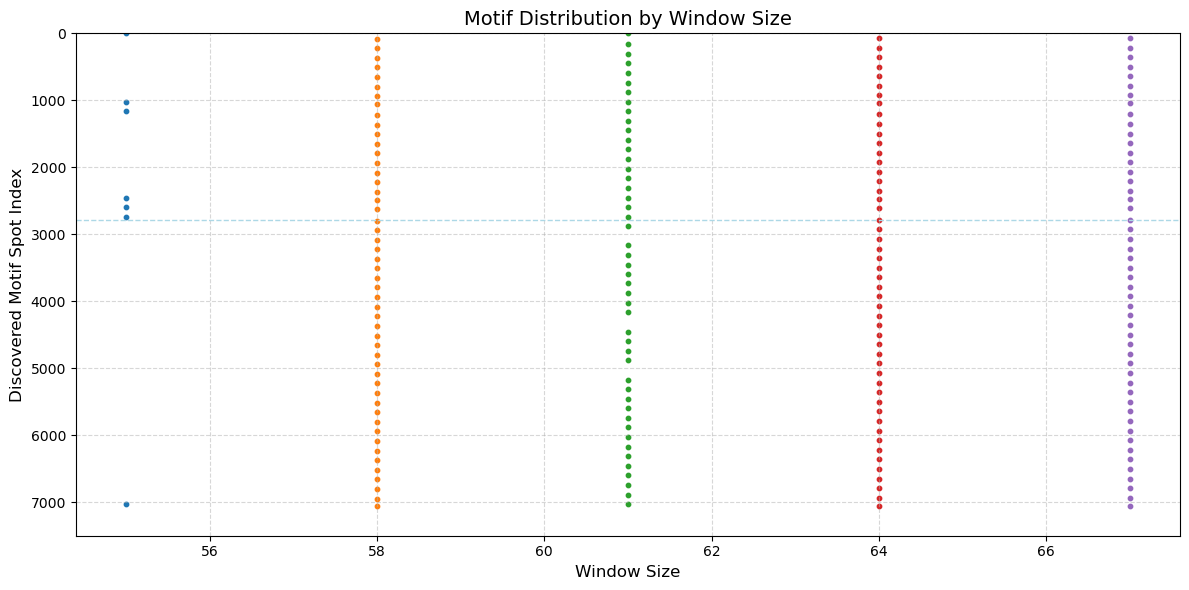

In [ ]:
# ---- Inputs ----
# Select the log to discover motifs from
# log_to_discover = srrt_plus_log
# log_to_discover_name = "SRRT_Plus"
# OR
log_to_discover = srrt_parallel_log
log_to_discover_name = "SRRT_Parallel"

ContextColumns = ["targetApp","eventType","url","target.workbookName","target.sheetName","target.id","target.class","target.tagName","target.type","target.name","target.innerText","target.checked","target.href","target.option","target.title","target.innerHTML"]

NumberOfMotifsToDiscover = 100
threshold = 0.8

smallest_window = 26 # Was 26 for experiment
largest_window = 68 # Was 68 for experiment
step_size = 1 # Was 1 for experiment

# If set to true, the experiment results will be saved to the folder "ExperimentResult"
save_experiment_to_folder = True

#########################
# ---- Do not change ----
#########################
# ---- Clean log ----
if "tuple:id" in log_to_discover.columns:
    log_to_discover = log_to_discover.drop(columns=["tuple:id"])

ui_log_encoded_w2v = util.util.encode_word2vec(log_to_discover, orderedColumnsList=ContextColumns, vector_size=50)

# ---- Generate ground truth ----
case_id_list = util.util.generate_caseid_list(log_to_discover, column="caseid")
cases_df = pd.DataFrame(case_id_list, columns=["caseid", "start_index", "length"])
groundTruth = cases_df["start_index"].tolist()
groundTruth_set = set(groundTruth)
ground_truth_sum = len(groundTruth)

# ---- Results container ----
results = []

# ---- Main loop ----
current_size = smallest_window
while current_size <= largest_window:
    print(f"Processing size: {current_size}")
    motif_distances, motif_indices, motif_subspaces, motif_mdls = util.util.mine_w2v(ui_log_encoded_w2v,current_size,NumberOfMotifsToDiscover)

    discovered_set = set(motif_indices[0])

    original_inserts_indexes, discovered_motif_spots, overlapDF = util.util.compute_discovery_coverage(case_id_list, set(motif_indices[0]), current_size, threshold=threshold)
    mean_coverage = 0
    
    if 'coverage' in overlapDF.columns:
        mean_coverage = overlapDF.loc[:, "coverage"].mean()
    else:
        mean_coverage = 0

    true_positives = len(original_inserts_indexes)
    false_positives = NumberOfMotifsToDiscover - true_positives
    false_negatives = ground_truth_sum - true_positives
    
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Filter the length of the discovered motifs
    filtered_df = cases_df[cases_df["start_index"].isin(original_inserts_indexes)]
    motif_length_list = list(filtered_df[["start_index", "length"]].itertuples(index=False, name=None))

    # print(f"Loop {size} completed. Results appending. F1-Score: {f1_score}, Precision: {precision}, Recall: {recall}, IuO: {mean_iou}.")
    results.append({
        'window_size': current_size,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'mean_coverage': mean_coverage,
        'discovered_indexes': set(overlapDF[["groundTruthStart", "groundTruthLength"]].itertuples(index=False, name=None)),
        'discovered_motif_spots': set(discovered_motif_spots),
        'motif_count': NumberOfMotifsToDiscover
    })
    current_size += step_size

# ---- Save the results ----
results_df = pd.DataFrame(results)
timestamp = datetime.now().strftime("%y%m%d_%H%M")
if save_experiment_to_folder:
    results_df.to_csv(f'ExperimentResult/EX2-windowSize_{log_to_discover_name}_{timestamp}.csv', index=False)
# print(results_df)

# ---- Plot F1-Score vs Window Size ----
plt.figure(figsize=(10, 6))
plt.plot(results_df['window_size'], results_df['f1_score'], marker='o', linewidth=2, label='F1-Score')
plt.plot(results_df['window_size'], results_df['recall'], marker='x', linewidth=2, label='Recall')
plt.plot(results_df['window_size'], results_df['precision'], marker='+', linewidth=2, label='Precision')
plt.plot(results_df['window_size'], results_df['mean_coverage'], marker='s', linewidth=2, label='Mean Coverage')

plt.title('Effect of Window Size on F1-Score', fontsize=16)
plt.xlabel('Window Size', fontsize=14)
plt.ylabel('F1-Score', fontsize=14)
plt.xticks(results_df['window_size'], rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.legend(fontsize=12)
# ---- Save to file ----
if save_experiment_to_folder:
    plt.savefig(f"ExperimentResult/EX2-windowSize_{log_to_discover_name}_plot-MetricResults_{timestamp}.png", dpi=300, bbox_inches='tight')
plt.show()

# ---- Motif Distribution Plot ----
plt.figure(figsize=(12, 6))

# Loop over each window size
for ws in sorted(results_df['window_size'].unique()):
    subset = results_df[results_df['window_size'] == ws]
    # Convert sets to sorted lists and flatten
    all_spots = []
    for entry in subset['discovered_motif_spots']:
        if isinstance(entry, set):
            all_spots.extend(sorted(entry))
        elif isinstance(entry, list):
            all_spots.extend(entry)
    x_vals = [ws] * len(all_spots)
    plt.scatter(x_vals, all_spots, label=f'Window Size {ws}', s=10)

plt.ylim(7500, 0)
plt.xlabel("Window Size", fontsize=12)
plt.ylabel("Discovered Motif Spot Index", fontsize=12)
plt.title("Motif Distribution by Window Size", fontsize=14)
if log_to_discover_name == "SRRT_Parallel":
    plt.axhline(y=2789, color='lightblue', linestyle='--', linewidth=1, label='Start of RT Traces') # Only works for SRRT_Joint
plt.grid(True, linestyle="--", alpha=0.5)
# plt.legend(title="Window Sizes", fontsize=9)
plt.tight_layout()
if save_experiment_to_folder:
    plt.savefig(f"ExperimentResult/EX2-windowSize_{log_to_discover_name}_plot-MotifDistribution_{timestamp}.png", dpi=300, bbox_inches='tight')
plt.show()

### C) Fixed Window Size, Flexible Number of motifs t

w_s = 30 and t=[5,10,20,30,40,50,60,70,80,90,100]

In the paper referred to as Step 3 / Experiment 3.

Processing Motif Count: 10
Processing Motif Count: 20
Processing Motif Count: 30
Processing Motif Count: 40
Processing Motif Count: 50
Processing Motif Count: 60
Processing Motif Count: 70
Processing Motif Count: 80
Processing Motif Count: 90
Processing Motif Count: 100


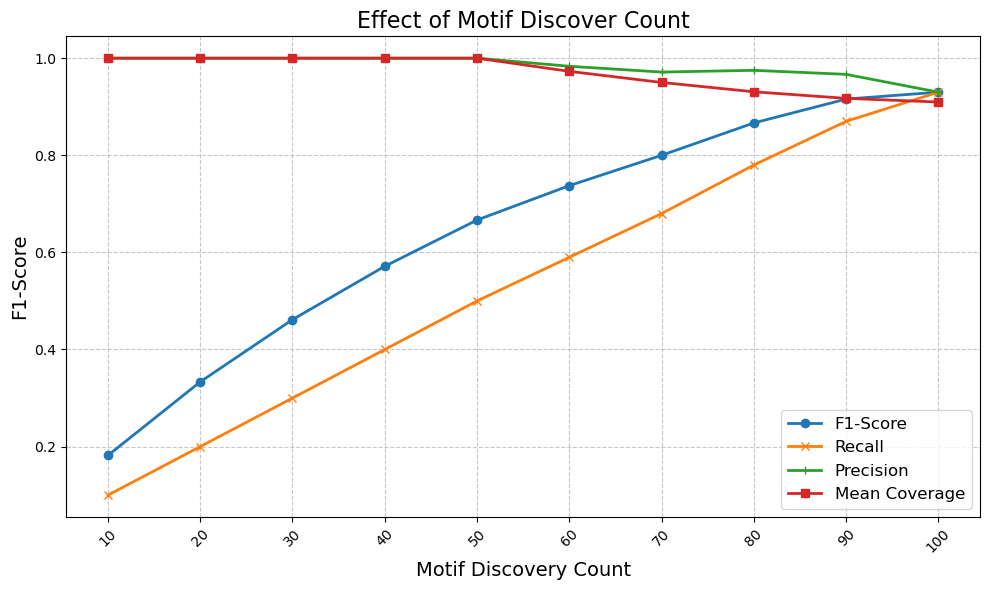

In [ ]:
# ---- Inputs ----
# Select the log to discover motifs from
log_to_discover = srrt_plus_log
log_to_discover_name = "SRRT_Plus"
# OR
# log_to_discover = srrt_parallel_log
# log_to_discover_name = "SRRT_Parallel"

ContextColumns = ["targetApp","eventType","url","target.workbookName","target.sheetName","target.id","target.class","target.tagName","target.type","target.name","target.innerText","target.checked","target.href","target.option","target.title","target.innerHTML"]

size = 30
threshold = 0.8

# If set to true, the experiment results will be saved to the folder "ExperimentResult"
save_experiment_to_folder = True

#########################
# ---- Do not change ----
#########################
# ---- Clean log ----
if "tuple:id" in log_to_discover.columns:
    log_to_discover = log_to_discover.drop(columns=["tuple:id"])

ui_log_encoded_w2v = util.util.encode_word2vec(log_to_discover, orderedColumnsList=ContextColumns, vector_size=50)

case_id_list = util.util.generate_caseid_list(log_to_discover, column="caseid")
cases_df = pd.DataFrame(case_id_list, columns=["caseid", "start_index", "length"])
groundTruth = cases_df["start_index"].tolist()
groundTruth_set = set(groundTruth)
ground_truth_sum = len(groundTruth)

# ---- Results container ----
results = []

# ---- Main loop ----
discoverable_motifs = [10,20,30,40,50,60,70,80,90,100]
discovery_repeat = False

# ---- Calculate the matrix profil once ----
# This is a performance optimization to avoid recalculating it in each loop
time_series_data, p_mult_matrix_profil, i_multi_motif_indexes = util.util.compute_matrix_profile(ui_log_encoded_w2v, size)

# ---- Loop through the discoverable motifs ----
for NumberOfMotifsToDiscover in discoverable_motifs:
    print(f"Processing Motif Count: {NumberOfMotifsToDiscover}")
    motif_distances, motif_indices, motif_subspaces, motif_mdls = util.util.extract_motifs(time_series_data, p_mult_matrix_profil, i_multi_motif_indexes, NumberOfMotifsToDiscover)   

    discovered_set = set(motif_indices[0])
    if discovered_set or discovery_repeat:

        # insert_spots, motif_spots, overlapDF = util.util.compare_sets(groundTruth_set, discovered_set, (size/2))
        original_inserts_indexes, discovered_motif_spots, overlapDF = util.util.compute_discovery_coverage(case_id_list, set(motif_indices[0]), size, threshold=threshold)
        mean_coverage = 0
        if 'coverage' in overlapDF.columns:
            mean_coverage = overlapDF.loc[:, "coverage"].mean()
        else:
            mean_coverage = 0

        true_positives = len(original_inserts_indexes)
        false_positives = NumberOfMotifsToDiscover - true_positives
        false_negatives = ground_truth_sum - true_positives
        
        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
        f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        # Filter the length of the discovered motifs
        # filtered_df = cases_df[cases_df["start_index"].isin(original_inserts_indexes)]
        # motif_length_list = list(filtered_df[["start_index", "length"]].itertuples(index=False, name=None))

        # print(f"Loop {size} completed. Results appending. F1-Score: {f1_score}, Precision: {precision}, Recall: {recall}, IuO: {mean_iou}.")
        results.append({
            'window_size': size,
            'precision': precision,
            'recall': recall,
            'f1_score': f1_score,
            'mean_coverage': mean_coverage,
            'discovered_indexes': set(overlapDF[["groundTruthStart", "groundTruthLength"]].itertuples(index=False, name=None)),
            'discovered_motif_spots': set(discovered_motif_spots),
            'motif_count': NumberOfMotifsToDiscover
        })
        discovery_repeat = False
    else:
        discovery_repeat = True


# ---- Save the results ----
results_df = pd.DataFrame(results)
timestamp = datetime.now().strftime("%y%m%d_%H%M")
if save_experiment_to_folder:
    results_df.to_csv(f'ExperimentResult/EX3-NoOfDiscovery_{log_to_discover_name}_{timestamp}.csv', index=False)
# print(results_df)

# ---- Plot F1-Score vs Window Size ----
plt.figure(figsize=(10, 6))
plt.plot(results_df['motif_count'], results_df['f1_score'], marker='o', linewidth=2, label='F1-Score')
plt.plot(results_df['motif_count'], results_df['recall'], marker='x', linewidth=2, label='Recall')
plt.plot(results_df['motif_count'], results_df['precision'], marker='+', linewidth=2, label='Precision')
plt.plot(results_df['motif_count'], results_df['mean_coverage'], marker='s', linewidth=2, label='Mean Coverage')

plt.title('Effect of Motif Discover Count', fontsize=16)
plt.xlabel('Motif Discovery Count', fontsize=14)
plt.ylabel('F1-Score', fontsize=14)
plt.xticks(results_df['motif_count'], rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.legend(fontsize=12)
# ---- Save to file ----
if save_experiment_to_folder:
    plt.savefig(f"ExperimentResult/EX3-NoOfDiscovery_{log_to_discover_name}_plot_{timestamp}.png", dpi=300, bbox_inches='tight')

### D) Cluster Purity Evaluation

Measure how well the identified motifs result in clusters that indicate if these then are "pure" for further processing in the RPM pipeline.

In the paper Step 4 / Experiment 4.

Window Size: 30, Motif Count: 10, Clusters: 1, Total Motifs: 10, Cluster Purity: 0.8


c:\Users\tomho\anaconda3\envs\timeSeriesData\lib\site-packages\umap\umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


Window Size: 30, Motif Count: 50, Clusters: 1, Total Motifs: 50, Cluster Purity: 0.92
Window Size: 30, Motif Count: 70, Clusters: 2, Total Motifs: 70, Cluster Purity: 0.857
Window Size: 30, Motif Count: 100, Clusters: 2, Total Motifs: 91, Cluster Purity: 0.89
Window Size: 40, Motif Count: 10, Clusters: 1, Total Motifs: 10, Cluster Purity: 0.6


c:\Users\tomho\anaconda3\envs\timeSeriesData\lib\site-packages\umap\umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


Window Size: 40, Motif Count: 50, Clusters: 3, Total Motifs: 50, Cluster Purity: 0.9
Window Size: 40, Motif Count: 70, Clusters: 3, Total Motifs: 51, Cluster Purity: 0.902
Window Size: 40, Motif Count: 100, Clusters: 3, Total Motifs: 51, Cluster Purity: 0.902
Window Size: 50, Motif Count: 10, Clusters: 1, Total Motifs: 10, Cluster Purity: 0.7


c:\Users\tomho\anaconda3\envs\timeSeriesData\lib\site-packages\umap\umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


Window Size: 50, Motif Count: 50, Clusters: 3, Total Motifs: 50, Cluster Purity: 0.92
Window Size: 50, Motif Count: 70, Clusters: 3, Total Motifs: 50, Cluster Purity: 0.92
Window Size: 50, Motif Count: 100, Clusters: 3, Total Motifs: 50, Cluster Purity: 0.92
Window Size: 60, Motif Count: 10, Clusters: 1, Total Motifs: 10, Cluster Purity: 0.8


c:\Users\tomho\anaconda3\envs\timeSeriesData\lib\site-packages\umap\umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


Window Size: 60, Motif Count: 50, Clusters: 2, Total Motifs: 50, Cluster Purity: 0.88
Window Size: 60, Motif Count: 70, Clusters: 2, Total Motifs: 51, Cluster Purity: 0.863
Window Size: 60, Motif Count: 100, Clusters: 2, Total Motifs: 51, Cluster Purity: 0.863
Window Size: 65, Motif Count: 10, Clusters: 1, Total Motifs: 10, Cluster Purity: 0.6


c:\Users\tomho\anaconda3\envs\timeSeriesData\lib\site-packages\umap\umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


Window Size: 65, Motif Count: 50, Clusters: 1, Total Motifs: 50, Cluster Purity: 0.9
Window Size: 65, Motif Count: 70, Clusters: 1, Total Motifs: 50, Cluster Purity: 0.9
Window Size: 65, Motif Count: 100, Clusters: 1, Total Motifs: 50, Cluster Purity: 0.9


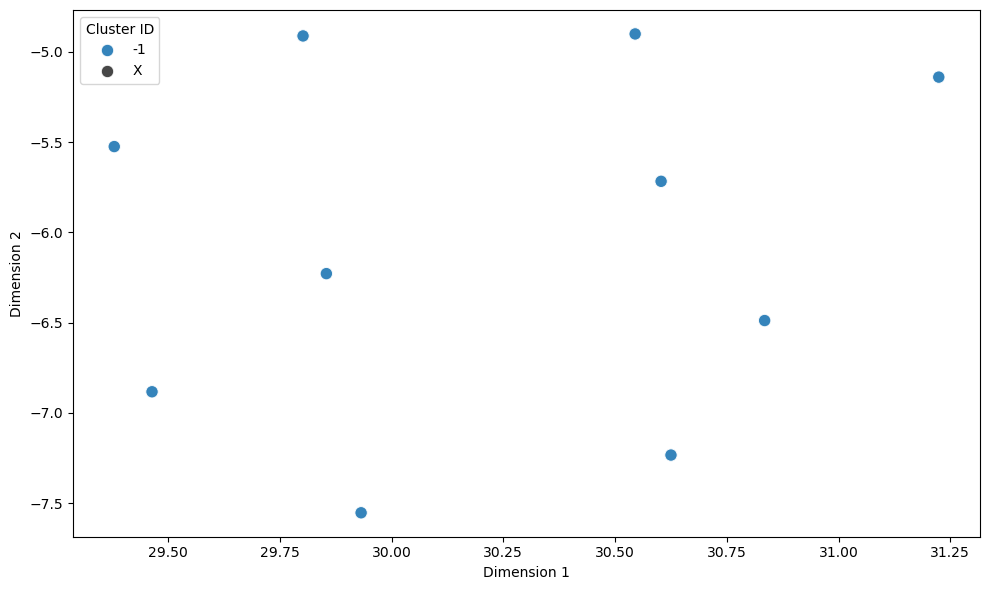

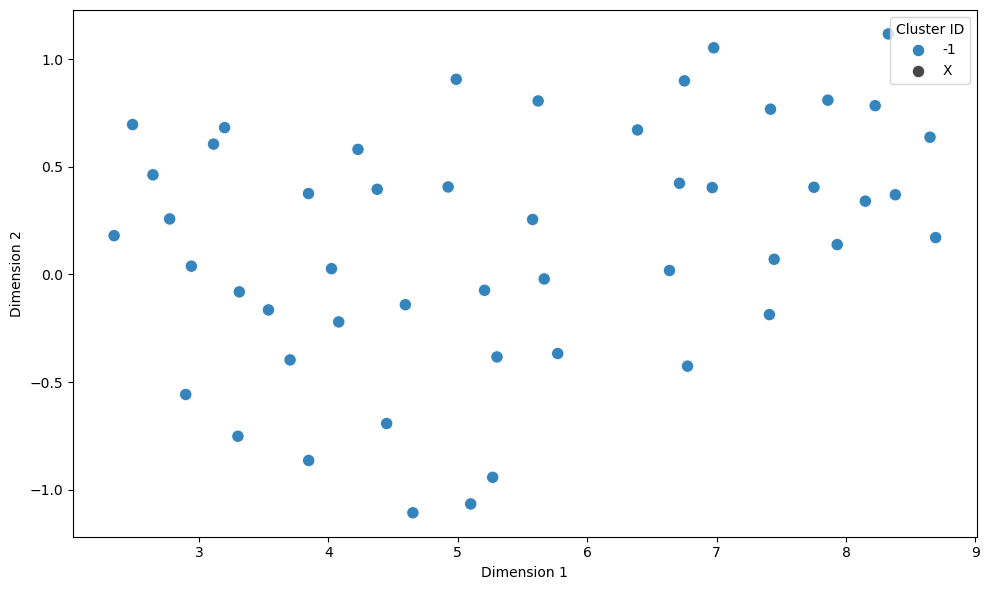

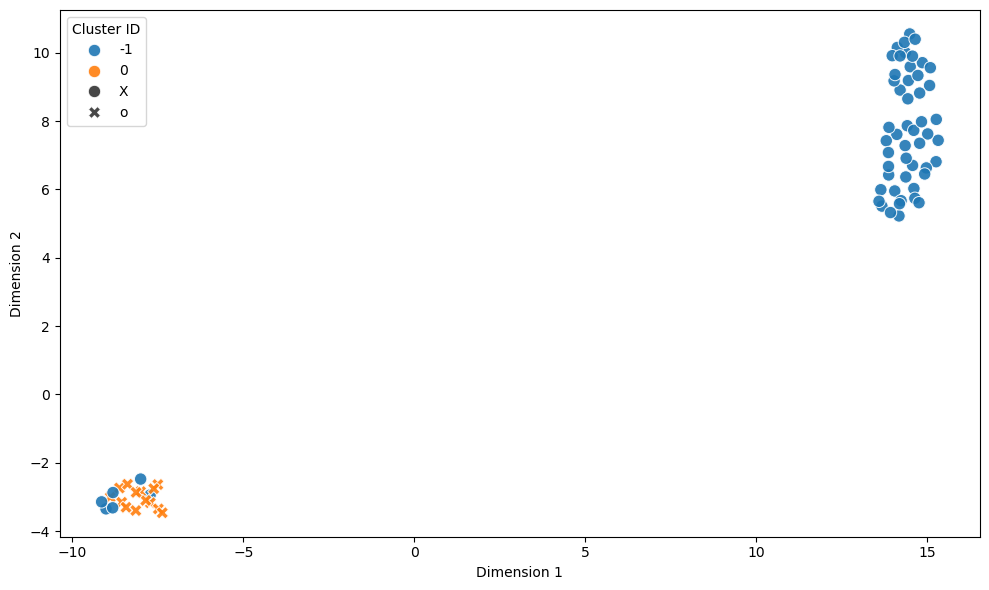

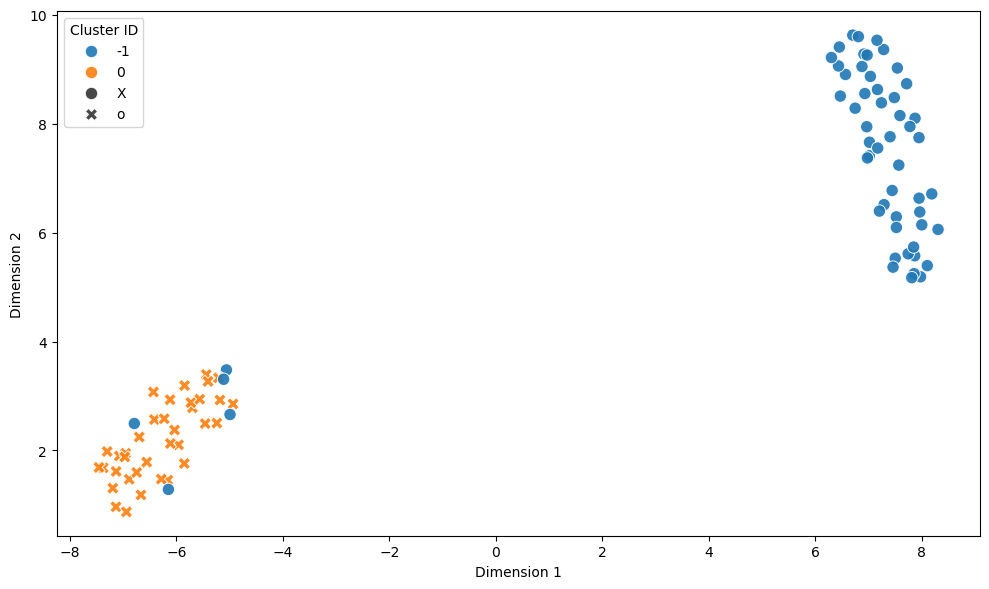

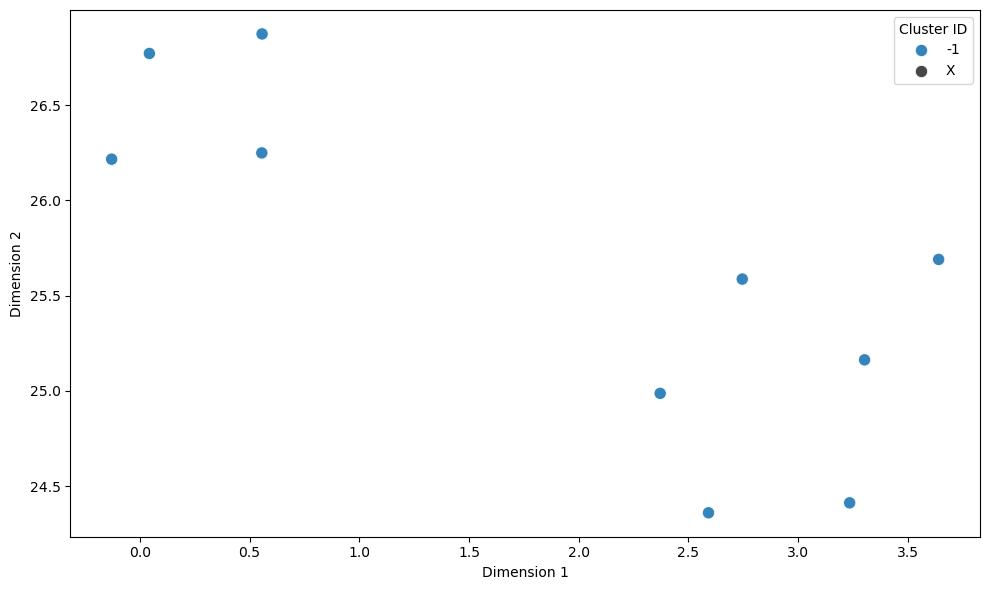

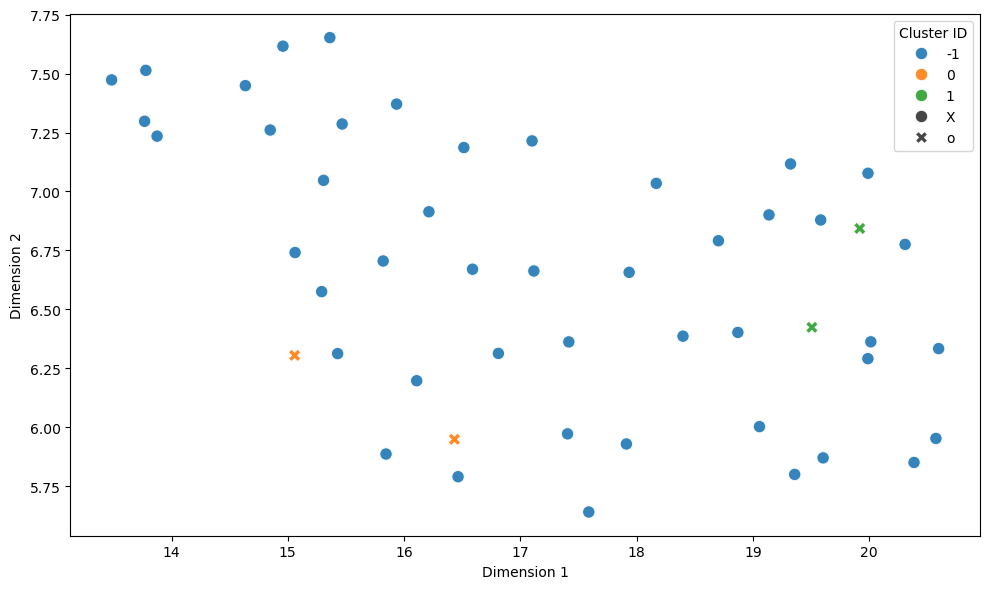

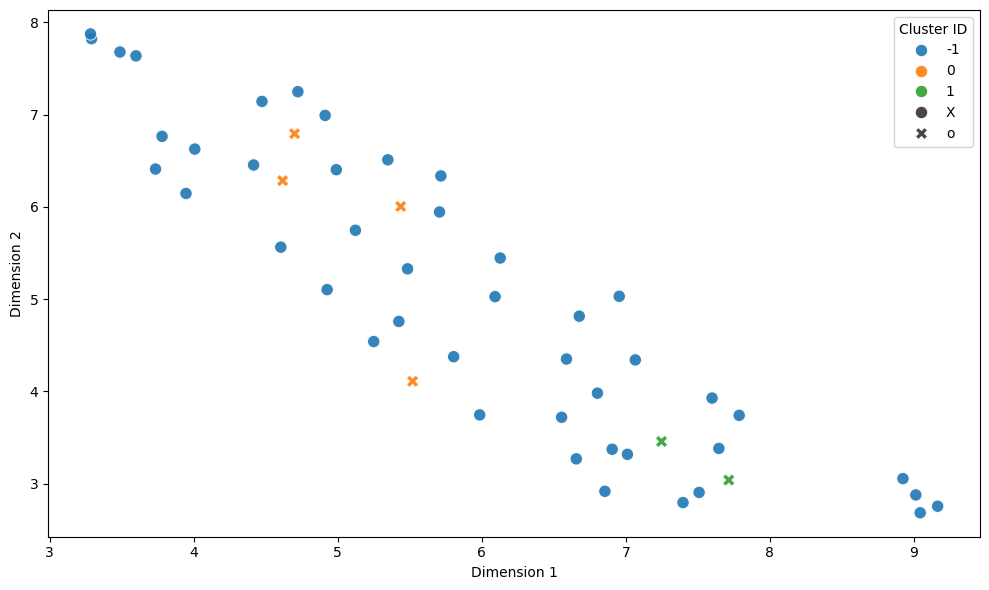

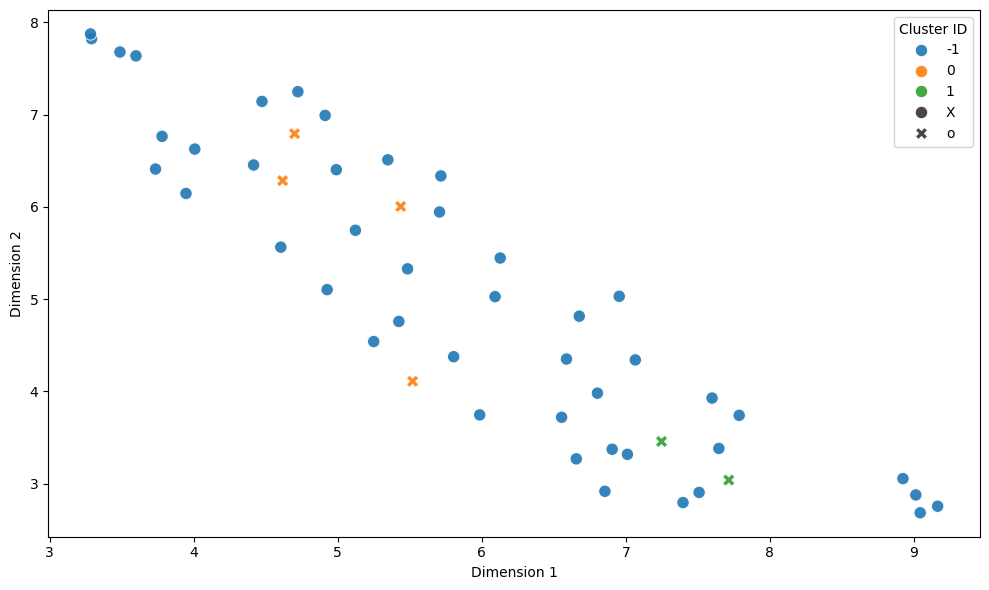

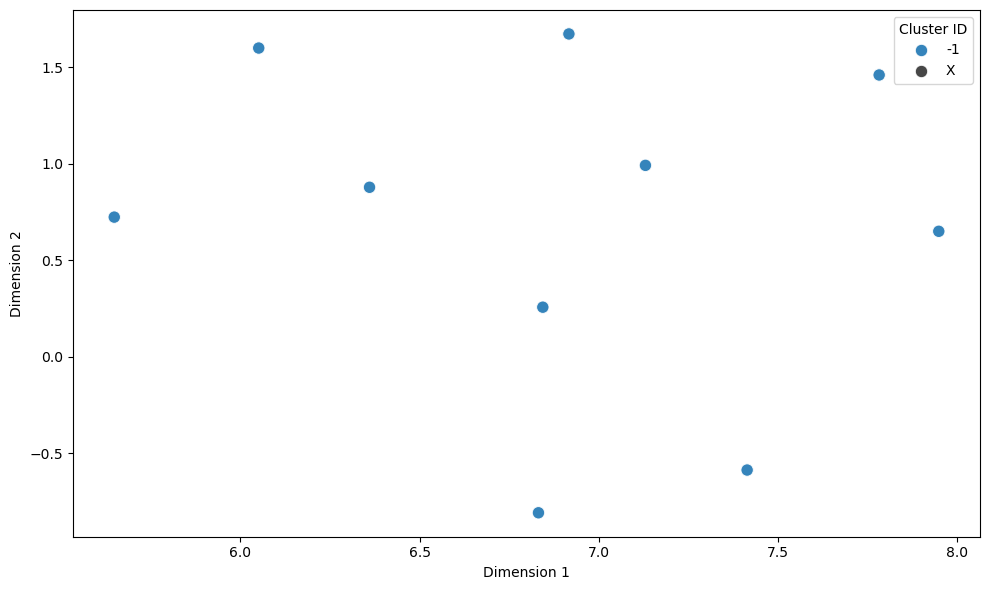

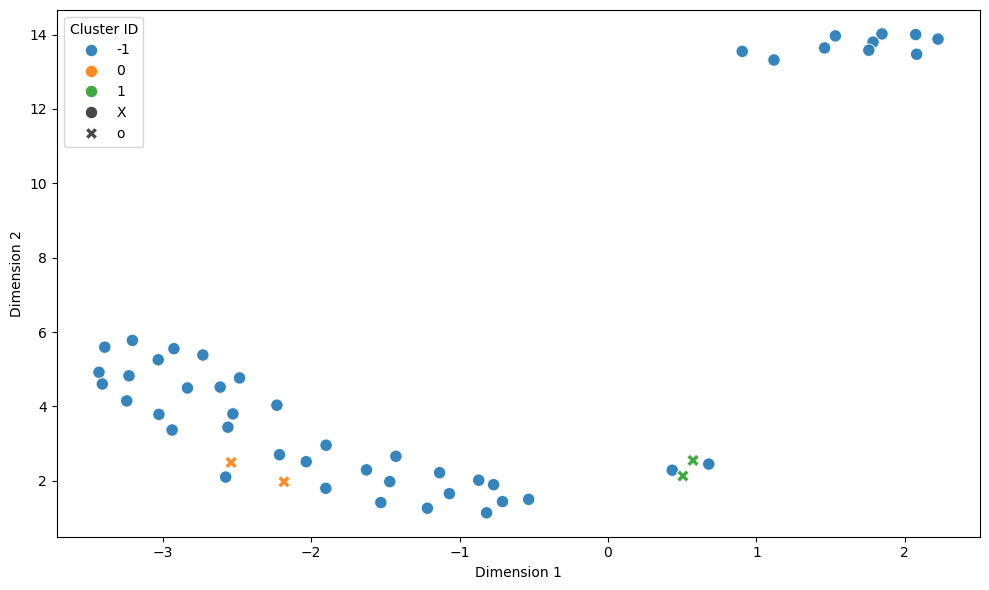

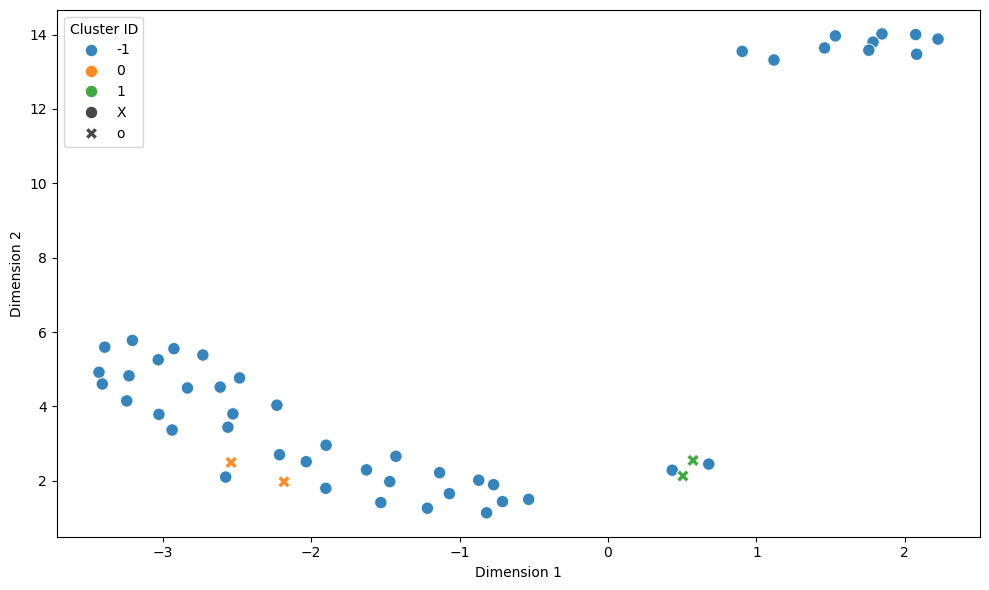

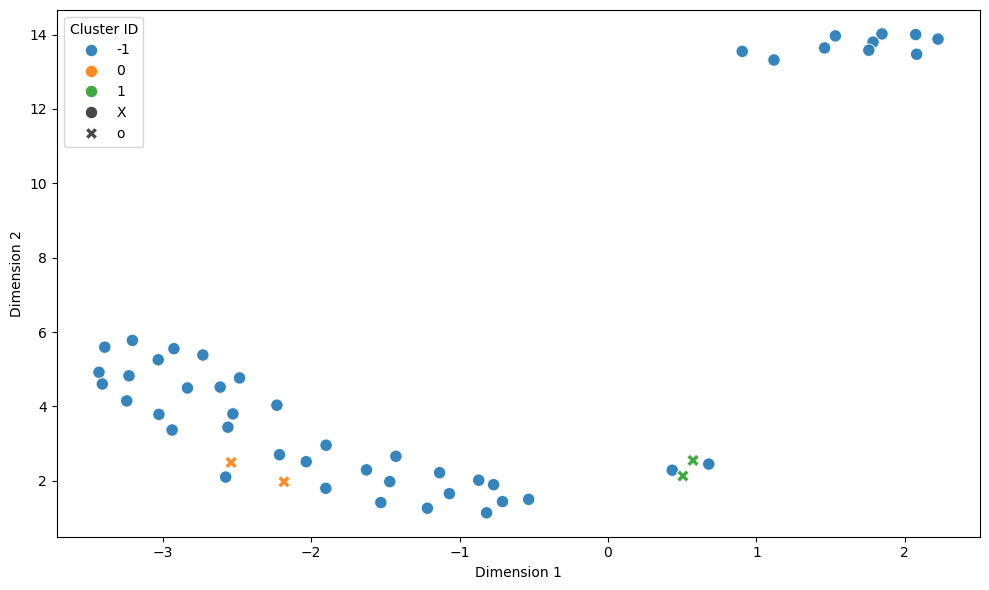

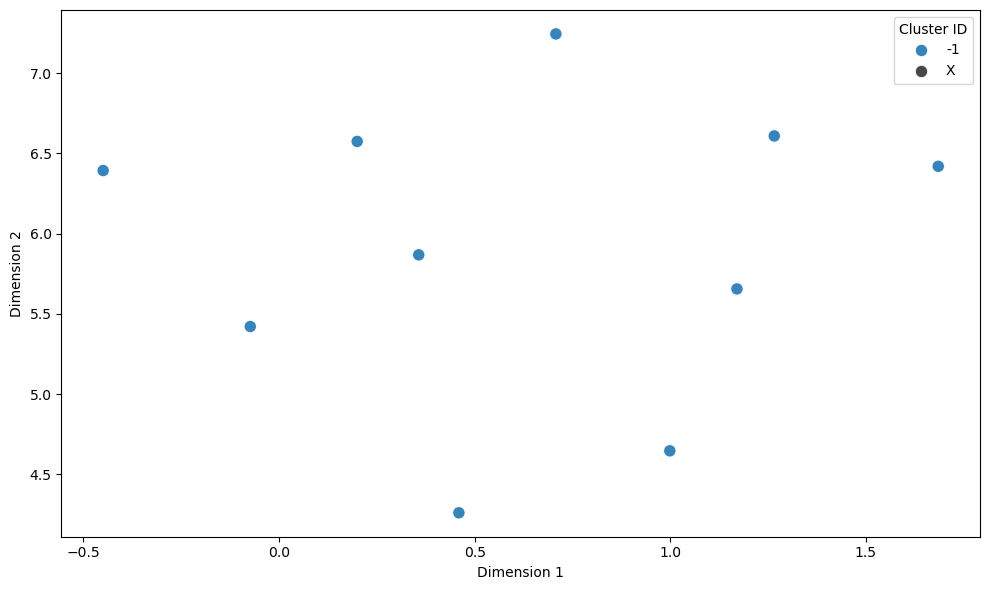

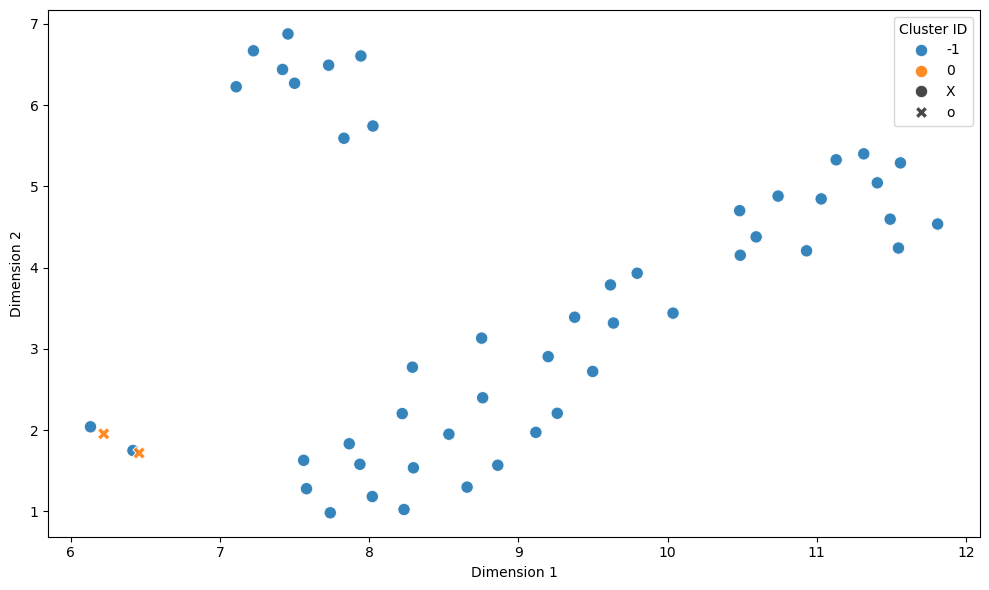

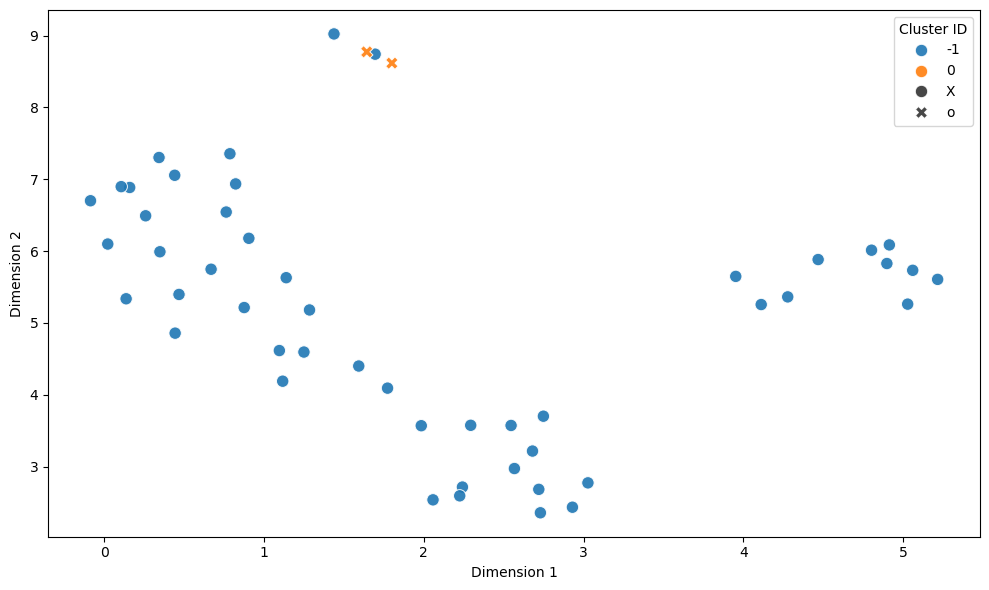

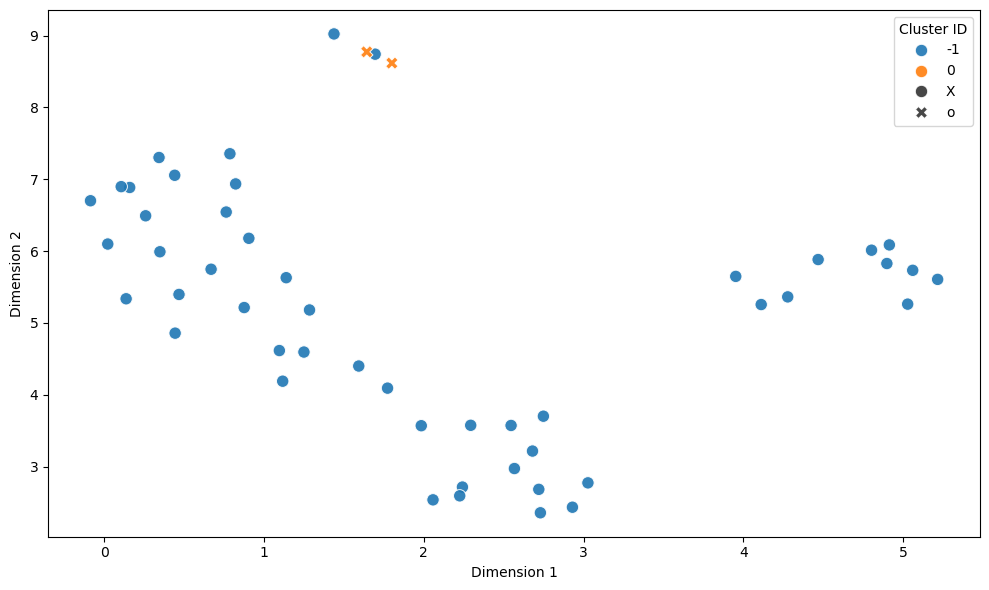

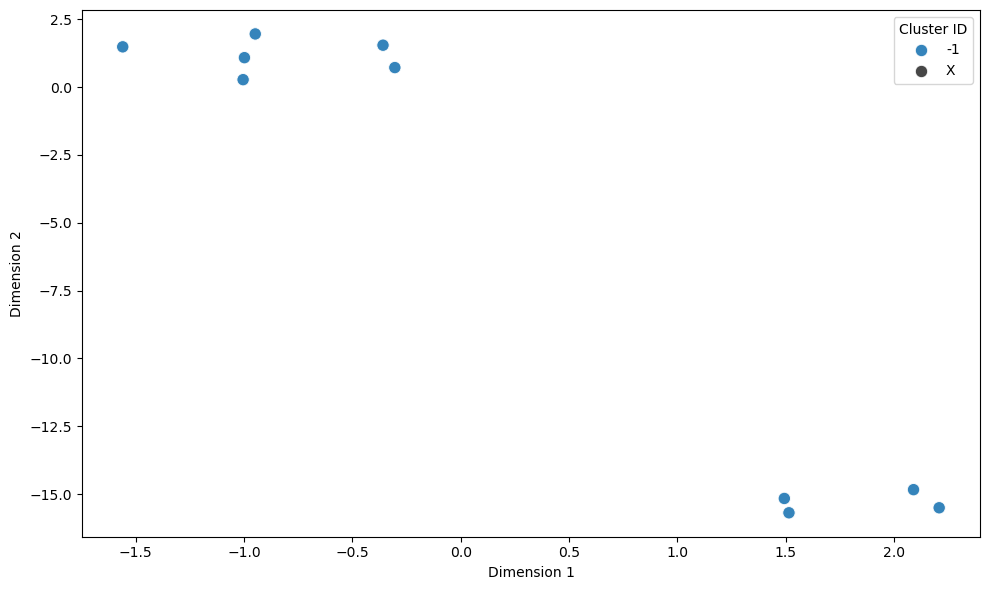

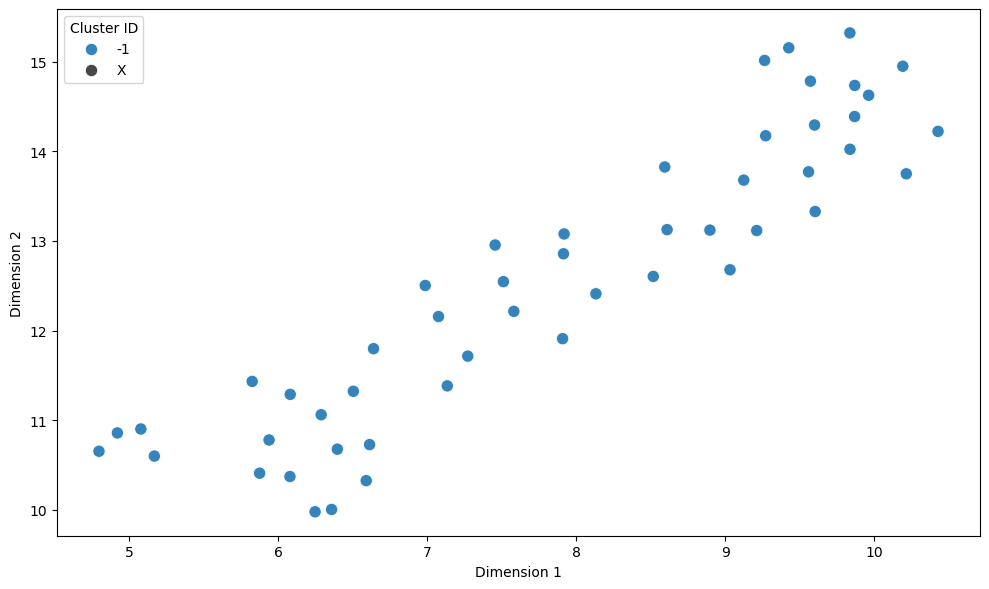

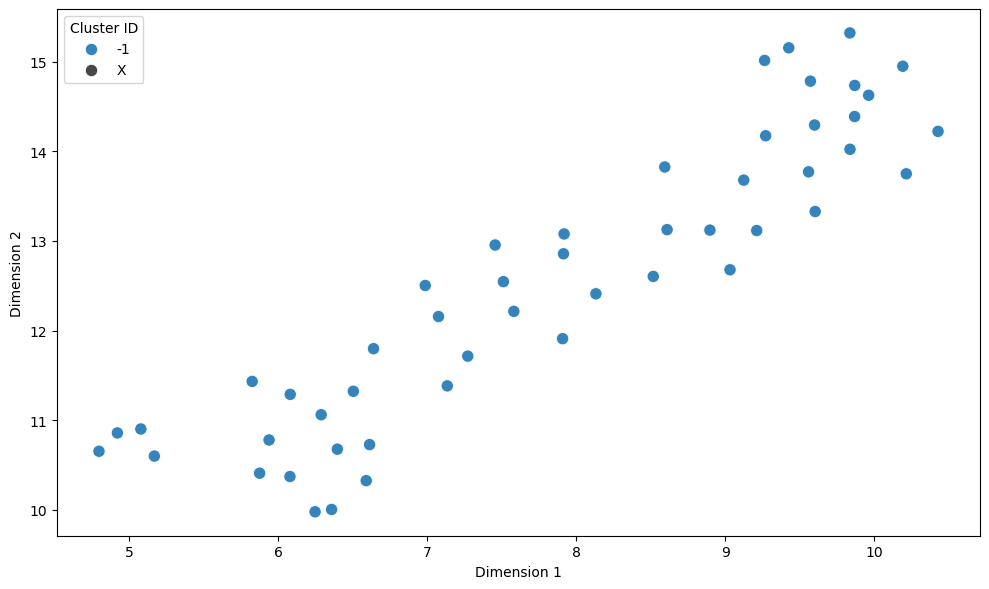

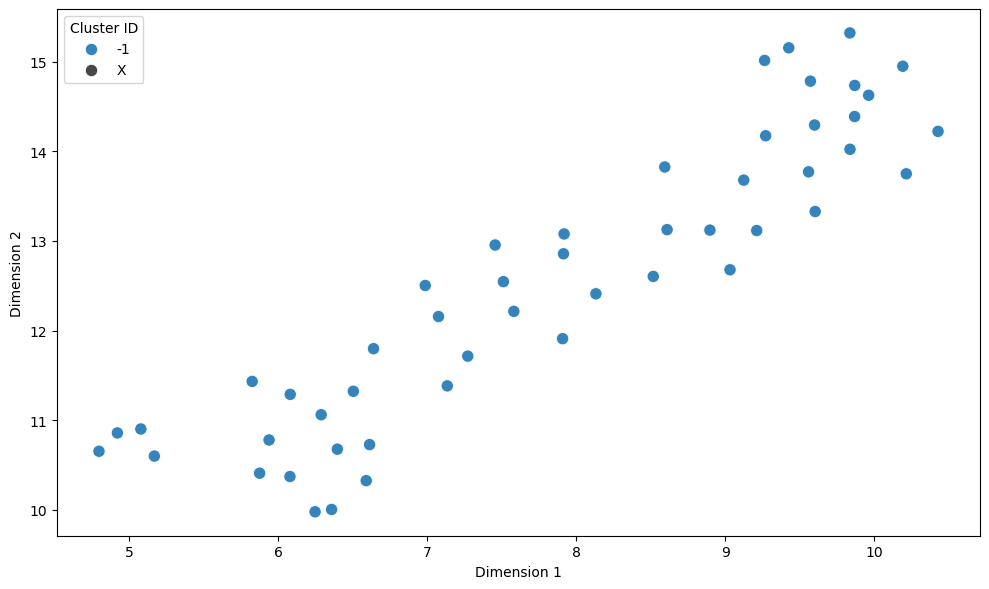

In [ ]:
# ---- Inputs ----
# Select the log to discover motifs from
# log_to_discover = srrt_plus_log
# log_to_discover_name = "SRRT_Plus"
# OR
log_to_discover = srrt_parallel_log
log_to_discover_name = "SRRT_Parallel"

ContextColumns = ["targetApp","eventType","url","target.workbookName","target.sheetName","target.id","target.class","target.tagName","target.type","target.name","target.innerText","target.checked","target.href","target.option","target.title","target.innerHTML"]

size = 30
threshold = 0.8

# ---- Experiment Parameters ----
window_sizes = [30, 40, 50, 60, 65]
motif_counts = [10, 50, 70, 100]

# ---- Routine Boundaries ----
short_range = (26, 36)  # SR routines
long_range = (56, 66)   # RT routines

# If set to true, the experiment results will be saved to the folder "ExperimentResult"
save_experiment_to_folder = True

#########################
# ---- Do not change ----
#########################

# ---- Label Function ----
def label_from_length(length):
    if short_range[0] <= length <= short_range[1]:
        return "SR"
    elif long_range[0] <= length <= long_range[1]:
        return "RT"
    else:
        return "Other"  # Noise or undefined

# ---- Clean log ----
if "tuple:id" in log_to_discover.columns:
    log_to_discover = log_to_discover.drop(columns=["tuple:id"])

ui_log_encoded_w2v = util.util.encode_word2vec(log_to_discover, orderedColumnsList=ContextColumns, vector_size=50)

case_id_list = util.util.generate_caseid_list(log_to_discover, column="caseid")
cases_df = pd.DataFrame(case_id_list, columns=["caseid", "start_index", "length"])
groundTruth = cases_df["start_index"].tolist()
groundTruth_set = set(groundTruth)
ground_truth_sum = len(groundTruth)

# ---- Results container ----
results = []

# ---- Create Image Folder ----
timestamp = datetime.now().strftime("%y%m%d_%H%M")
if save_experiment_to_folder:
    import os
    image_path = f"ExperimentResult/EX4-ClusterPurity_{log_to_discover_name}_Evaluation_{timestamp}"
    if not os.path.exists(image_path):
        os.makedirs(image_path)

# ---- Loop over configurations ----
for size in window_sizes:
    time_series_data, p_mult_matrix_profil, i_multi_motif_indexes = util.util.compute_matrix_profile(
        ui_log_encoded_w2v, size)

    for NumberOfMotifsToDiscover in motif_counts:
        motif_distances, motif_indices, motif_subspaces, motif_mdls = util.util.extract_motifs(
            time_series_data, p_mult_matrix_profil, i_multi_motif_indexes, NumberOfMotifsToDiscover
        )

        discovered_set = set(motif_indices[0])
        _, _, overlapDF = util.util.compute_discovery_coverage(
            case_id_list, discovered_set, size, threshold=threshold)

        df_clusters = util.util.cluster_motifs_with_word2vec(ui_log_encoded_w2v, list(discovered_set), size)
        length_map = dict(zip(overlapDF["discoveredMotif"], overlapDF["groundTruthLength"]))
        df_clusters["length"] = df_clusters["start_index"].map(length_map)
        df_clusters["label"] = df_clusters["length"].apply(lambda l: label_from_length(l) if pd.notnull(l) else "Unknown")

        N = len(df_clusters)
        purity_total = 0
        cluster_details = []

        for cluster_id, group in df_clusters.groupby("routine_id"):
            label_counts = group["label"].value_counts()
            dominant_label = label_counts.idxmax() if not label_counts.empty else "None"
            dominant_count = label_counts.max() if not label_counts.empty else 0
            cluster_size = len(group)
            cluster_purity = dominant_count / cluster_size if cluster_size > 0 else 0
            purity_total += dominant_count

            # Identify ground truth matched motifs
            matched_motifs = group[group["label"] != "Unknown"]
            num_matched = len(matched_motifs)
            matched_lengths = matched_motifs["length"].dropna().astype(int).tolist()

            cluster_details.append({
                "cluster_id": cluster_id,
                "dominant_label": dominant_label,
                "purity": round(cluster_purity, 3),
                "cluster_size": cluster_size,
                "matched_motifs": num_matched,
                "matched_lengths": matched_lengths
            })

        overall_purity = purity_total / N if N > 0 else 0
        experiment_index_value = f"{size}_{NumberOfMotifsToDiscover}"

        results.append({
            "experiment_index": experiment_index_value,
            "window_size": size,
            "to_discover_motif_count": NumberOfMotifsToDiscover,
            "num_clusters": df_clusters["routine_id"].nunique(),
            "discovered_total_motifs": N,
            "cluster_purity": round(overall_purity, 3),
            "cluster_details": cluster_details
        })

        print(f"Window Size: {size}, Motif Count: {NumberOfMotifsToDiscover}, "
              f"Clusters: {df_clusters['routine_id'].nunique()}, Total Motifs: {N}, "
              f"Cluster Purity: {round(overall_purity, 3)}")

        fig = util.util.plot_motif_clusters(df_clusters)
        if save_experiment_to_folder:
            fig.savefig(f"{image_path}/{experiment_index_value}.png")

# ---- Save the results ----
df_results = pd.DataFrame(results)

if save_experiment_to_folder:
    df_results.to_csv(f"ExperimentResult/EX4-ClusterPurity_{log_to_discover_name}_Evaluation_{timestamp}.csv", index=False)